# Visualization of bnn performance metrics

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from pathlib import Path

In [2]:
results = pd.read_parquet(str(Path(os.getcwd()).parent) + '/src/artifacts/results.parquet')

In [3]:
results

,dataset_id,prior,split,rmse,nll,cov90,iw90,cov95,iw95,accept_rate,num_draws,seed,arch,activation,sigma_lik,nu,prior_scale,init_scheme
0,openml-191,isotropic_gaussian,id,1.017703,1.457787,0.914894,3.355084,0.978723,3.926488,0.352154,5000,0,"[32, 50, 50, 1]",tanh,1.0,5.0,1.0,isotropic_gaussian
1,openml-191,isotropic_gaussian,ood,0.909111,1.386322,0.950000,3.258585,0.975000,3.898395,0.352154,5000,0,"[32, 50, 50, 1]",tanh,1.0,5.0,1.0,isotropic_gaussian
2,openml-197,isotropic_gaussian,id,0.281902,1.241260,0.995036,3.268481,0.996841,3.873987,0.318615,5000,1,"[21, 50, 50, 1]",tanh,1.0,5.0,1.0,isotropic_gaussian
3,openml-197,isotropic_gaussian,ood,0.497849,1.398987,0.975217,3.315059,0.985130,3.922729,0.318615,5000,1,"[21, 50, 50, 1]",tanh,1.0,5.0,1.0,isotropic_gaussian
4,openml-201,isotropic_gaussian,id,0.495058,1.462352,0.999643,3.271475,1.000000,3.875286,0.290154,5000,2,"[26, 50, 50, 1]",tanh,1.0,5.0,1.0,isotropic_gaussian
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,openml-593,student_t,ood,1.502588,1.549491,0.630000,3.278869,0.780000,3.876728,0.344000,5000,27,"[10, 50, 50, 1]",tanh,1.0,5.0,1.0,isotropic_gaussian
176,openml-595,student_t,id,0.528279,1.399944,0.995833,3.295834,1.000000,3.893832,0.342308,5000,28,"[10, 50, 50, 1]",tanh,1.0,5.0,1.0,isotropic_gaussian
177,openml-595,student_t,ood,0.596537,1.645865,0.995000,3.298725,1.000000,3.900137,0.342308,5000,28,"[10, 50, 50, 1]",tanh,1.0,5.0,1.0,isotropic_gaussian
178,openml-598,student_t,id,0.674849,1.468115,0.962500,3.289456,0.995833,3.889243,0.328923,5000,29,"[25, 50, 50, 1]",tanh,1.0,5.0,1.0,isotropic_gaussian


Index(['dataset_id', 'prior', 'split', 'rmse', 'nll', 'cov90', 'iw90', 'cov95',
       'iw95', 'accept_rate', 'num_draws', 'seed', 'arch', 'activation',
       'sigma_lik', 'nu', 'prior_scale', 'init_scheme'],
      dtype='object')

In [4]:
prior_colors = {
    'isotropic_gaussian': plt.get_cmap('tab10')(0),
    'student_t': plt.get_cmap('tab10')(1),
    'laplace': plt.get_cmap('tab10')(2),
}

In [5]:
def plot_result_histograms_per_prior(results: pd.DataFrame, col: str) -> None:
    x = results[col]
    print('min:', x.min(), 'max:', x.max())

    bins = np.linspace(x.min(), x.max(), 50)

    # Define priors
    priors = ['isotropic_gaussian', 'student_t', 'laplace']

    # Plot histograms
    plt.figure(figsize=(8, 5))
    for prior in priors:
        filtered_results = results[results['prior'] == prior]
        x = filtered_results[col]

        plt.hist(
            x,
            bins=bins,
            alpha=0.6,
            label=prior,
            edgecolor='black',
            color=prior_colors[prior]
        )

    plt.xlabel('Negative Log-Likelihood')
    plt.ylabel('Count')
    plt.title(f'BNN {col} Distribution by Prior')
    plt.legend()
    plt.tight_layout()
    plt.show()

min: 1.1450157165527344 max: 1.8217483758926392


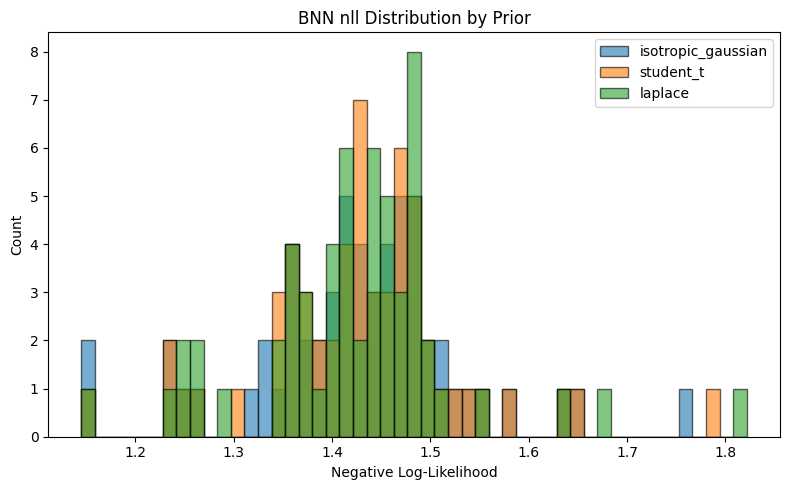

In [6]:
plot_result_histograms_per_prior(results, 'nll')

min: 0.32692310214042664 max: 1.0


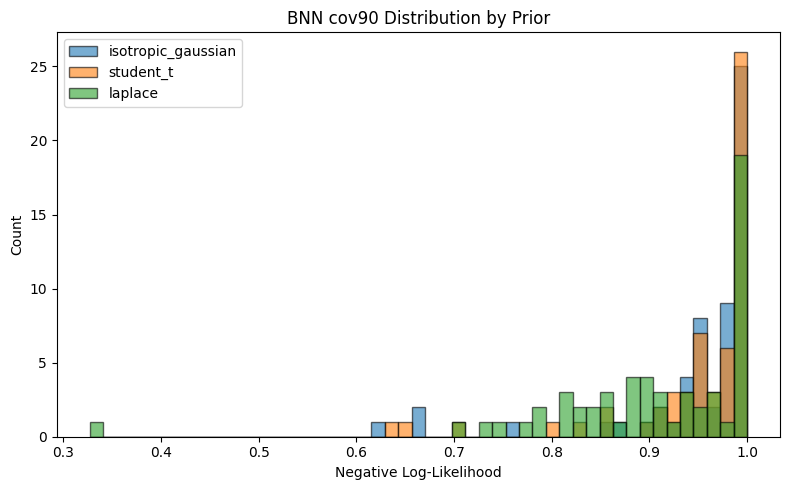

In [7]:
plot_result_histograms_per_prior(results, 'cov90')

min: 0.0 max: 0.4004615247249603


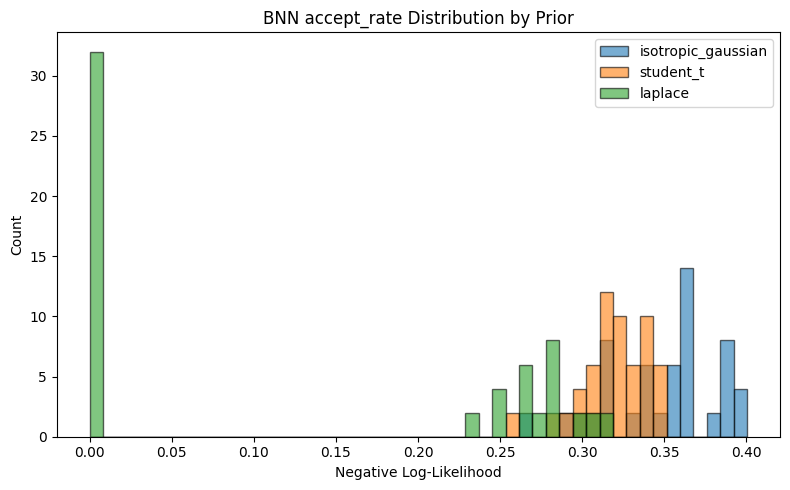

In [8]:
plot_result_histograms_per_prior(results, 'accept_rate')

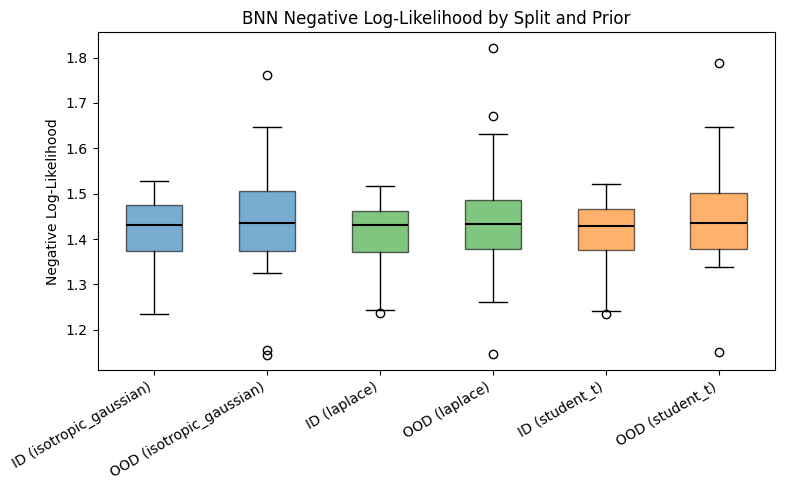

In [10]:
split_results = results.dropna(subset=['split', 'nll', 'prior'])

split_order = ['id', 'ood']

priors = split_results['prior'].unique()
cmap = plt.get_cmap('Set2')
colors = [cmap(i % cmap.N) for i in range(len(priors))]

data = []
labels = []
box_colors = []

for prior in priors:
    color = prior_colors[prior]
    for split in split_order:
        subset = split_results[
            (split_results['prior'] == prior) & (split_results['split'] == split)
        ]['nll']
        data.append(subset)
        labels.append(f"{split.upper()} ({prior})")
        box_colors.append(color)

plt.figure(figsize=(8, 5))

positions = np.arange(len(data)) + 1
bp = plt.boxplot(data, patch_artist=True, positions=positions, medianprops={'color': 'black', 'linewidth': 1.5})

for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

plt.xticks(positions, labels, rotation=30, ha='right')
plt.ylabel('Negative Log-Likelihood')
plt.title('BNN Negative Log-Likelihood by Split and Prior')
plt.tight_layout()
plt.show()
